# 08-2 합성곱 신경망을 사용한 이미지 분류
케라스 API를 사용해 합성곱 신경망 모델을 만들어 패션 MNIST 이미지를 분류하는 방법을 배운다.

## 패션 MNIST 데이터 불러오기

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1,28,28,1)/255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)
# 입력 이미지는 항상 깊이(채널) 차원이 있어야 한다. 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 한다.
# train_input (48000, 28, 28) -> train_scaled (48000, 28, 28, 1)

## 합성곱 신경망 만들기

In [5]:
# Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D 추가
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [6]:
# 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2))

In [7]:
# 첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [8]:
# 3차원 특성 맵을 일렬로 펼친다.
# 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)              

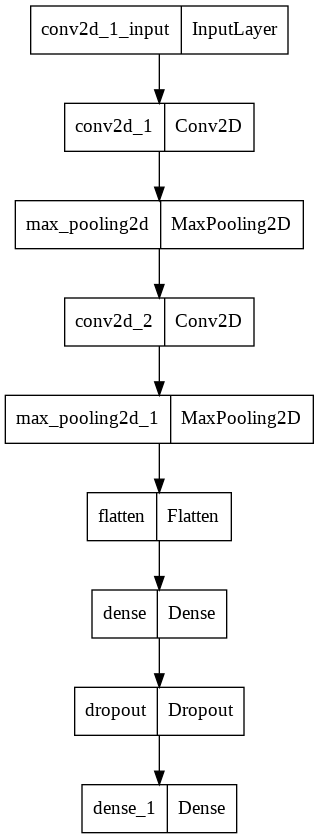

In [10]:
keras.utils.plot_model(model)

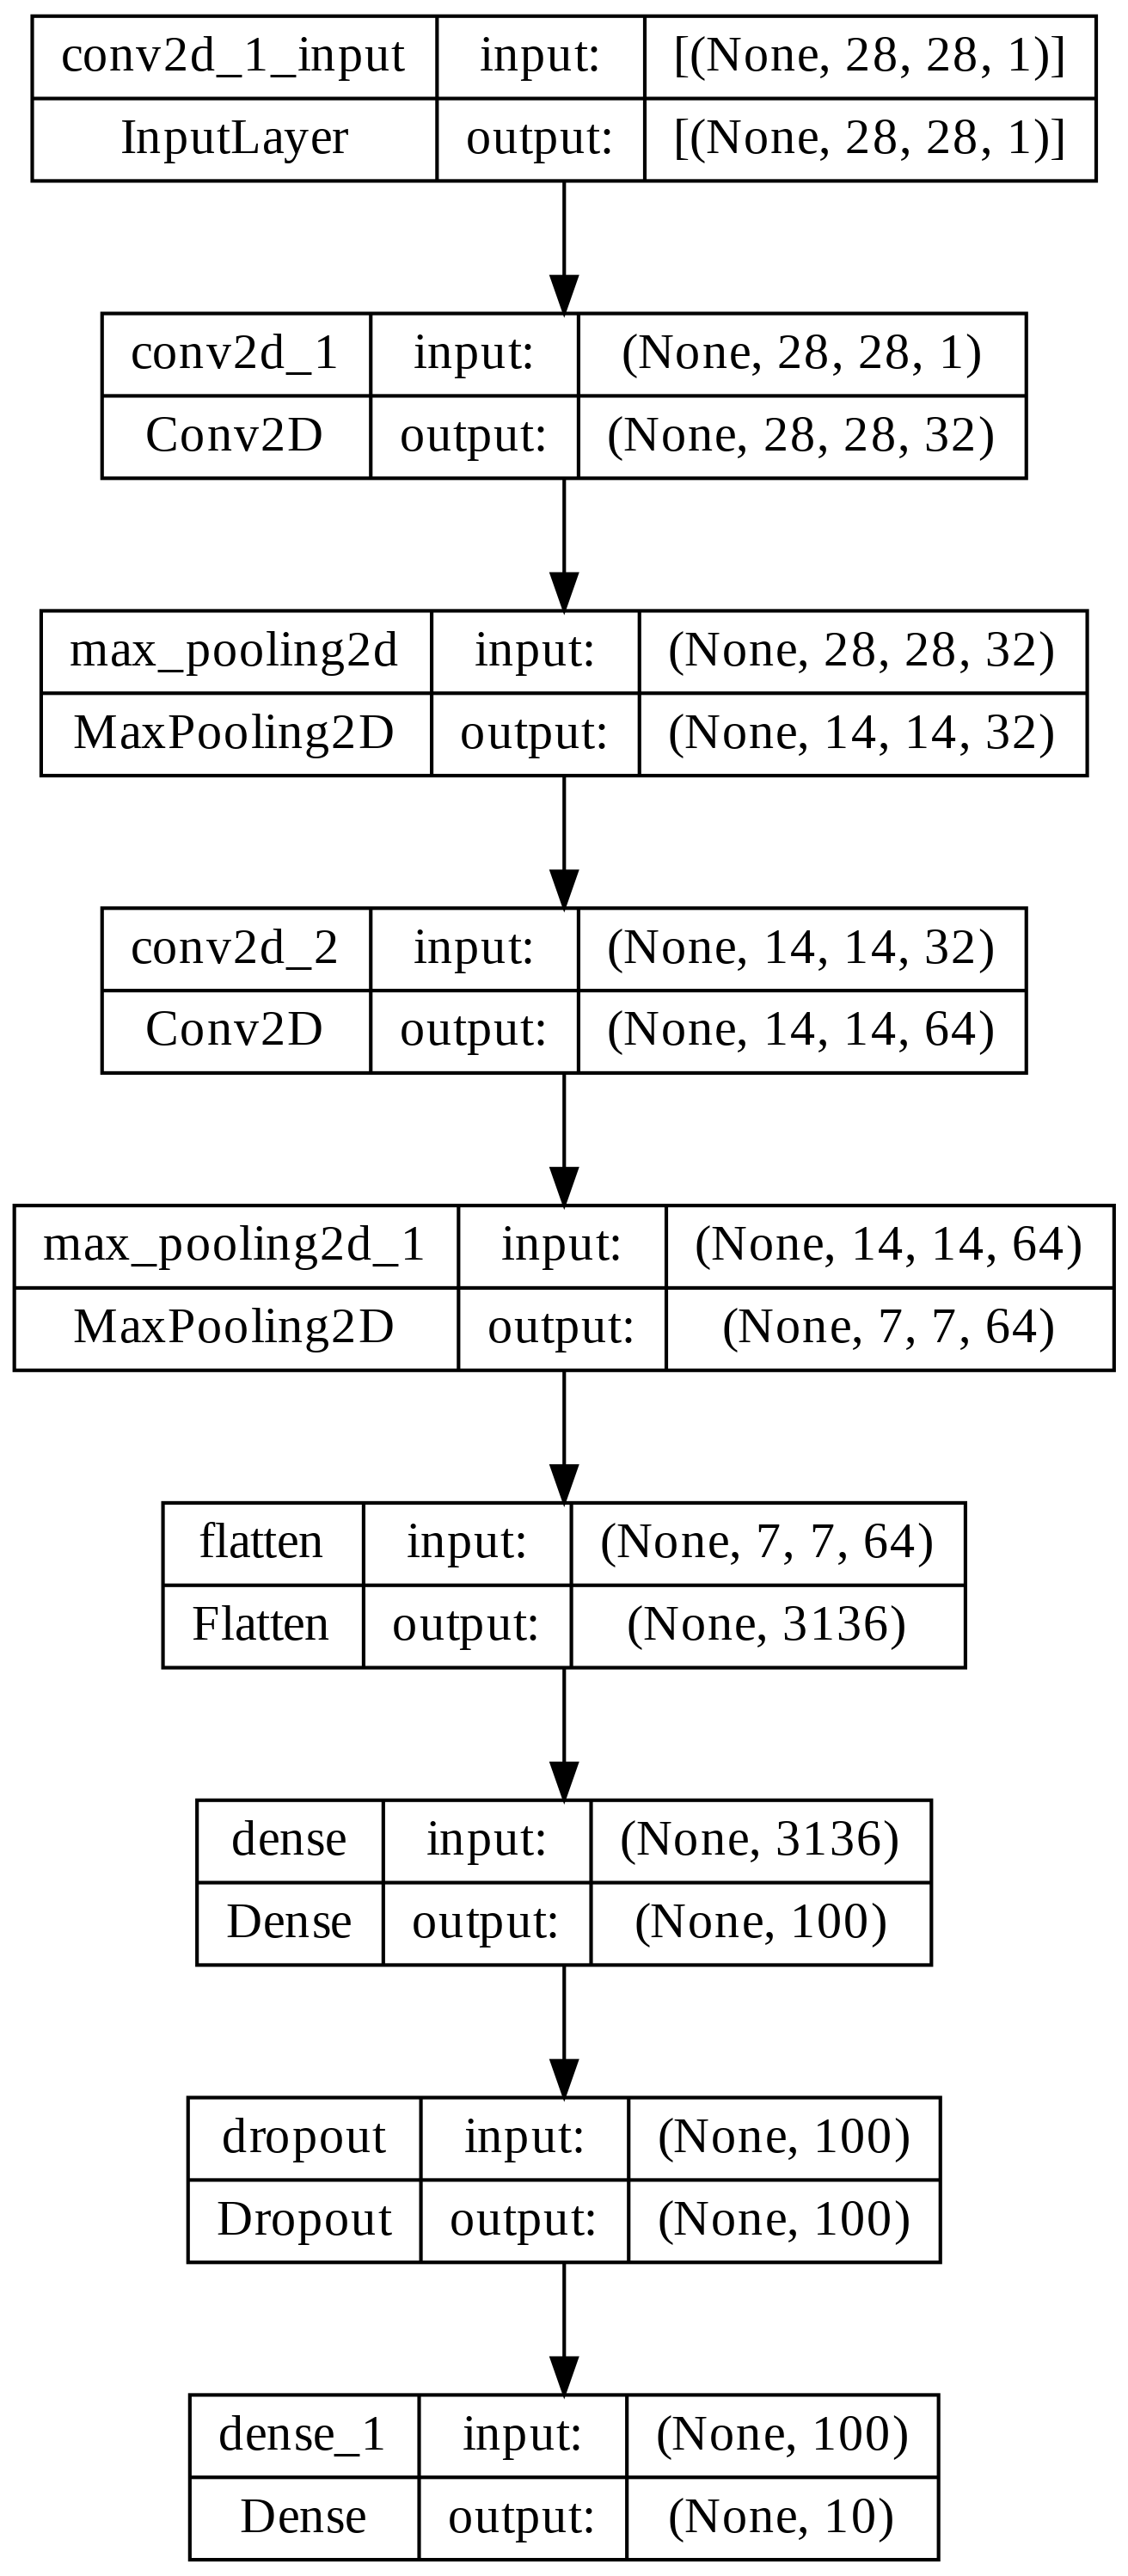

In [11]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn_architecture.png', dpi=300)

지금까지 만든 신경망을 그림으로 살펴보면 다음과 같다.
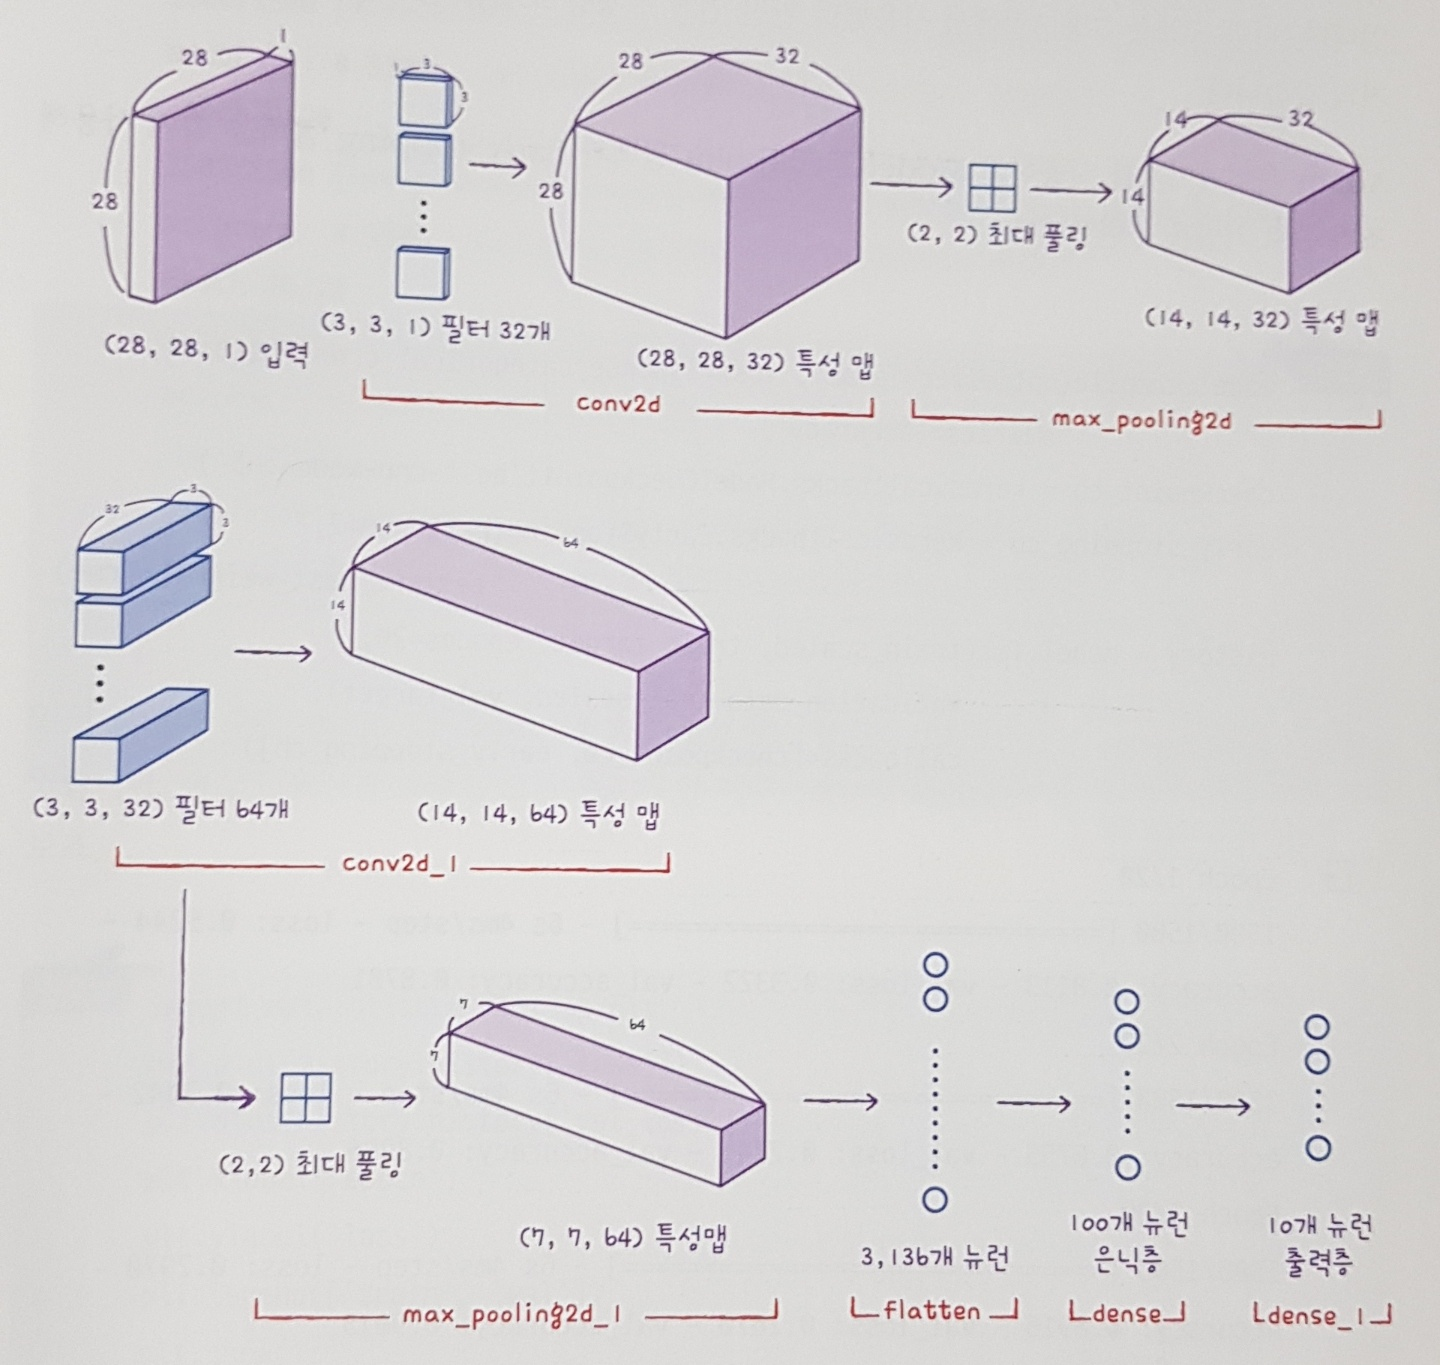

## 모델 컴파일과 훈련

In [12]:
# Adam 옵티마이저를 사용하고, ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 15s 4ms/step - loss: 0.5320 - accuracy: 0.8080 - val_loss: 0.3351 - val_accuracy: 0.8734
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3593 - accuracy: 0.8709 - val_loss: 0.2793 - val_accuracy: 0.8949
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3044 - accuracy: 0.8899 - val_loss: 0.2560 - val_accuracy: 0.9046
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2721 - accuracy: 0.9013 - val_loss: 0.2420 - val_accuracy: 0.9104
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2486 - accuracy: 0.9091 - val_loss: 0.2294 - val_accuracy: 0.9162
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2276 - accuracy: 0.9157 - val_loss: 0.2187 - val_accuracy: 0.9207
Epoch 7/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2091 - accuracy: 0.9211 - val_loss: 0.2207 - val_accuracy

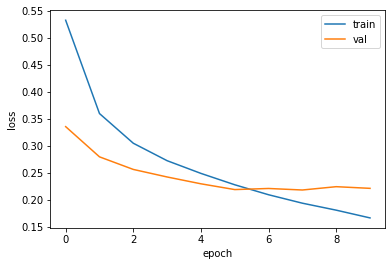

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있다.
# 즉 ModelCheckpoint 콜백이 저장한 파일을 다시 읽을 필요가 없음.

In [14]:
model.evaluate(val_scaled, val_target)

# 이 결과는 fit() 메서드의 출력 중 아홉 번째 에포크의 출력과 동일한데,
# 이는 EarlyStopping 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원한 것을 알 수 있음

375/375 [==============================] - 1s 3ms/step - loss: 0.2179 - accuracy: 0.9206


[0.21790319681167603, 0.9205833077430725]

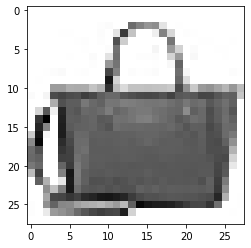

In [15]:
plt.imshow(val_scaled[0].reshape(28,28),cmap='gray_r')
plt.show()

# 첫 번째 샘플 이미지 살펴보기

In [16]:
preds = model.predict(val_scaled[0:1])
print(preds)

# 이 이미지에 대한 모델의 예측을 살펴본다. predict() 메서드는 10개의 클래스에 대한 예측 확률을 출력한다.
# 샘플 하나를 전달할 때 (28,28,1)이 아닌 (1,28,28,1) 크기를 전달해야 하는데, 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1) 크기를 만든다.

1/1 [==============================] - 0s 130ms/step
[[9.7817366e-16 1.5930143e-18 1.7095602e-22 4.8868825e-13 3.9072931e-18
  2.3770131e-15 5.1612216e-17 3.8795502e-14 1.0000000e+00 1.8960086e-16]]


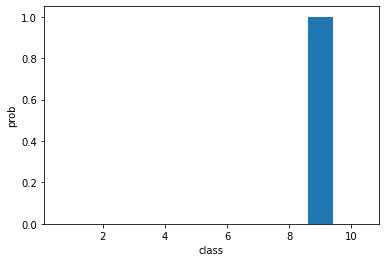

In [17]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [18]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방','앵클 부츠']

In [19]:
import numpy as np
print(classes[np.argmax(preds)])

# preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용

가방


In [20]:
# 마지막으로 맨 처음에 떼어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능을 가늠해 본다.
test_scaled = test_input.reshape(-1,28,28,1)/255.0

In [21]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2409 - accuracy: 0.9125


[0.24090656638145447, 0.9125000238418579]